In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from scipy.stats import poisson
from scipy.optimize import minimize

import warnings
warnings.filterwarnings('ignore')

In [2]:
SHAPE = 2
SCALE = 0.5
N_SIMS_PROB = 10000

REAL_PARS = np.random.gamma(SHAPE, SCALE, 40)

In [3]:
def simulate_championship(real_pars, inx):
    games = dict()
    for i in range(1, 21):
        games[f'Clube {i}'] = dict()
        for j in range(1, 21):
            if i == j: continue
            home = np.random.poisson(real_pars[inx[f'Clube {i}']['Atk']] / real_pars[inx[f'Clube {j}']['Def']])
            away = np.random.poisson(real_pars[inx[f'Clube {j}']['Atk']] / real_pars[inx[f'Clube {i}']['Def']])
            games[f'Clube {i}'][f'Clube {j}'] = [home, away]

    return games

In [4]:
def generate_data(real_pars, inx, seasons = 1):
    data = dict()
    for i in range(seasons):
        data[i] = simulate_championship(real_pars, inx)
    
    return data

In [5]:
def likelihood(parameters, played_games, inx):
    lik = 0
    for i in range(len(played_games)):
        for home in played_games[i]:
            for away in played_games[i][home]:
                result = played_games[i][home][away]
                inx_1, inx_2 = inx[home]['Atk'] - 1, inx[away]['Def'] - 1
                if parameters[inx_2] == 0: return np.inf
                if inx_1 == -1: mu0 = 1 / parameters[inx_2]
                else: mu0 = parameters[inx_1] / parameters[inx_2]
                lik -= poisson.logpmf(result[0], mu0)

                inx_1, inx_2 = inx[away]['Atk'] - 1, inx[home]['Def'] - 1
                if parameters[inx_2] == 0: return np.inf
                if inx_1 == -1: mu1 = 1 / parameters[inx_2]
                else: mu1 = parameters[inx_1] / parameters[inx_2]
                lik -= poisson.logpmf(result[1], mu1)
    
    return lik

In [6]:
def estimate_probs(pars, inx, n_sims):
    probs = dict()
    for home in inx:
        if home not in probs: probs[home] = dict()
        for away in inx:
            if home == away: continue
            home_atk = pars[inx[home]['Atk']]
            home_def = pars[inx[home]['Def']]
            away_atk = pars[inx[away]['Atk']]
            away_def = pars[inx[away]['Def']]

            results = np.zeros((n_sims, 2))
            results[:, 0] = np.random.poisson(home_atk / away_def, n_sims)
            results[:, 1] = np.random.poisson(away_atk / home_def, n_sims)
            p_home = np.sum(results[:, 0] > results[:, 1]) / n_sims
            p_draw = np.sum(results[:, 0] == results[:, 1]) / n_sims
            p_away = abs(round(1 - p_home - p_draw, 4))
            probs[home][away] = [p_home, p_draw, p_away]

    return probs

In [7]:
def game_to_vector(score):
    if score[0] > score[1]: return np.array([1, 0, 0])
    if score[0] < score[1]: return np.array([0, 0, 1])
    return np.array([0, 1, 0])

In [8]:
BOUNDS = list()
INX = dict()
ind = 0
for i in range(1, 21):
    INX[f'Clube {i}'] = dict()
    INX[f'Clube {i}']['Atk'] = ind
    if ind != 0: BOUNDS.append((0, None))
    ind += 1
    INX[f'Clube {i}']['Def'] = ind
    BOUNDS.append((0, None))
    ind += 1

DATA = generate_data(REAL_PARS, INX, seasons = 5)

In [9]:
def optimize_pars():
    res = minimize(likelihood, np.random.random(2 * len(DATA[0]) - 1),
                   args = (DATA, INX), bounds = BOUNDS)
    
    return np.hstack([[1], res.x])

In [10]:
def calculate_deFinetti(n_estimatives = 10):
    df = pd.DataFrame(columns = ['Mode', 'De Finetti'])
    count = 0
    results = None
    real_deFinetti = 0
    data = simulate_championship(REAL_PARS, INX)
    real_probs = estimate_probs(REAL_PARS, INX, N_SIMS_PROB)
    estimated_deFinetti_list = [0 for _ in range(n_estimatives)]
    estimated_pars_list = [optimize_pars() for _ in range(n_estimatives)]
    estimated_probs_list = [estimate_probs(estimated_pars_list[i], INX, N_SIMS_PROB) for i in range(n_estimatives)]
    for home in data:
        for away in data:
            if home == away: continue
            result = game_to_vector(data[home][away])
            results = result if results is None else np.vstack([results, result])
            real_deFinetti += np.linalg.norm(result - real_probs[home][away]) ** 2
            for i in range(n_estimatives): estimated_deFinetti_list[i] += np.linalg.norm(result - estimated_probs_list[i][home][away]) ** 2
            count += 1
    
    df.loc[len(df)] = ['Real pars', real_deFinetti / count]
    for i in range(n_estimatives): df.loc[len(df)] = [f'Estimated pars {i+1}', estimated_deFinetti_list[i] / count]
    df.loc[len(df)] = ['Avg. estimated pars', np.mean(estimated_deFinetti_list) / count]
    df.loc[len(df)] = ['Marginal', np.mean(np.sum((results - np.mean(results, axis = 0)) ** 2, axis = 1))]
    df.loc[len(df)] = ['Naive', 2 / 3]
    
    return df.sort_values('De Finetti', ignore_index = True)

In [11]:
calculate_deFinetti()

,Mode,De Finetti
0,Real pars,0.487425
1,Estimated pars 4,0.490667
2,Estimated pars 6,0.491170
3,Marginal,0.652687
4,Avg. estimated pars,0.658613
5,Naive,0.666667
6,Estimated pars 3,0.667427
7,Estimated pars 2,0.670371
8,Estimated pars 10,0.679864
9,Estimated pars 5,0.683517


## De Finetti view

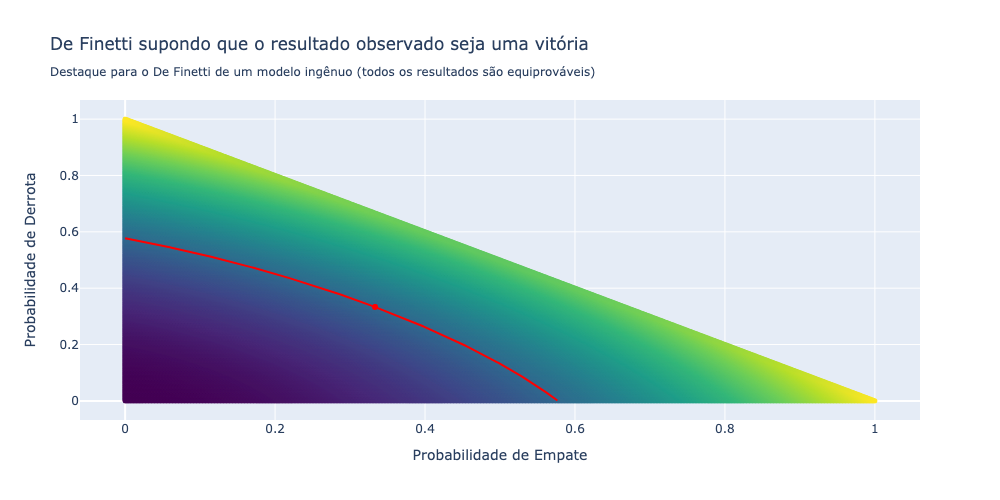

In [12]:
n_points = 500
x = np.linspace(0, 1, n_points)
y = np.linspace(0, 1, n_points)

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
inx = (xv + yv) <= 1

zv = xv ** 2 + yv ** 2 + (xv + yv) ** 2
xv = xv[inx]
yv = yv[inx]
zv = zv[inx]
heatmap_trace = go.Scatter(
                           x = xv,
                           y = yv,
                           showlegend = False,
                           mode = 'markers',
                           marker = dict(size = 5,
                                         color = zv,
                                         colorscale = 'Viridis')
                          )

line_x = np.linspace(0, 1, 1000)
line_y = .5 * ((((4 - 9 * line_x ** 2) ** .5)) / 3 ** .5 - line_x)
line_x = line_x[line_y >= 0]
line_y = line_y[line_y >= 0]
line_trace = go.Scatter(x = line_x,
                        y = line_y,
                        showlegend = False,
                        mode = 'lines',
                        line = dict(color = 'red',
                                    width = 2)
                       )

point_trace = go.Scatter(x = [1/3],
                         y = [1/3],
                         showlegend = False,
                         mode = 'markers',
                         marker = dict(color = 'red')
                        )

fig = go.Figure([heatmap_trace, line_trace, point_trace])
fig.update_xaxes(title='Probabilidade de Empate')
fig.update_yaxes(title='Probabilidade de Derrota')
fig.update_layout(width = 1000,
                  title = 'De Finetti supondo que o resultado observado seja uma vitória<br><sub>Destaque para o De Finetti de um modelo ingênuo (todos os resultados são equiprováveis)</sub>')

fig.show('png')

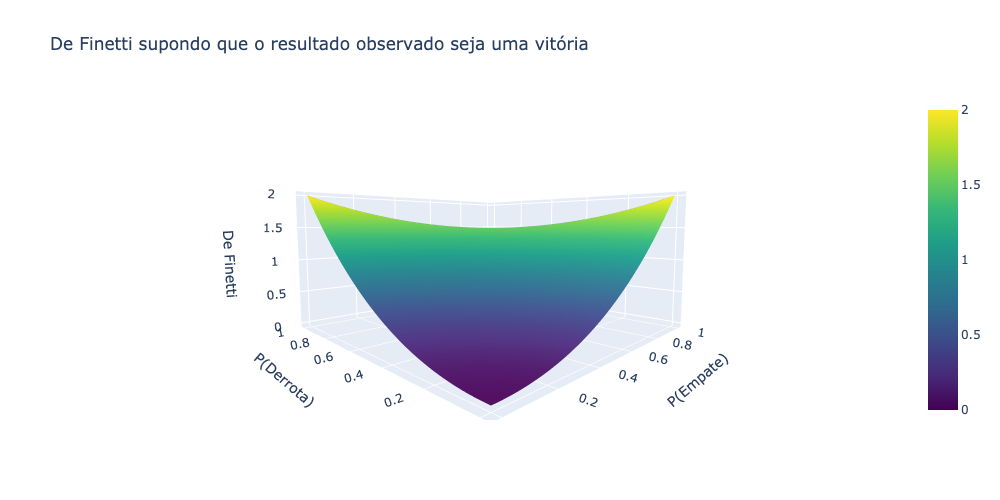

In [13]:
n_points = 500
x = np.linspace(0, 1, n_points)
y = np.linspace(0, 1, n_points)
xv, yv = np.meshgrid(x, y)
zv = xv ** 2 + yv ** 2 + (xv + yv) ** 2

inx = (xv + yv) > 1
xv[inx] = None
yv[inx] = None
zv[inx] = None

fig = go.Figure(go.Surface(x = xv,
                           y = yv,
                           z = zv,
                           colorscale = 'viridis'
                          )
               )

fig.update_layout(scene = dict(
                               xaxis_title = 'P(Empate)',
                               yaxis_title = 'P(Derrota)',
                               zaxis_title = 'De Finetti',
                               aspectmode = 'manual',
                               aspectratio = dict(x = 2, y = 2, z = 1),
                               camera = dict(eye = dict(x = -2, y = -2, z = 0.25),
                                             center = dict(x = 0, y = 0, z = 0))
                              )
                 )

fig.update_layout(width = 1000,
                  title = 'De Finetti supondo que o resultado observado seja uma vitória'
                 )

fig.show('png')

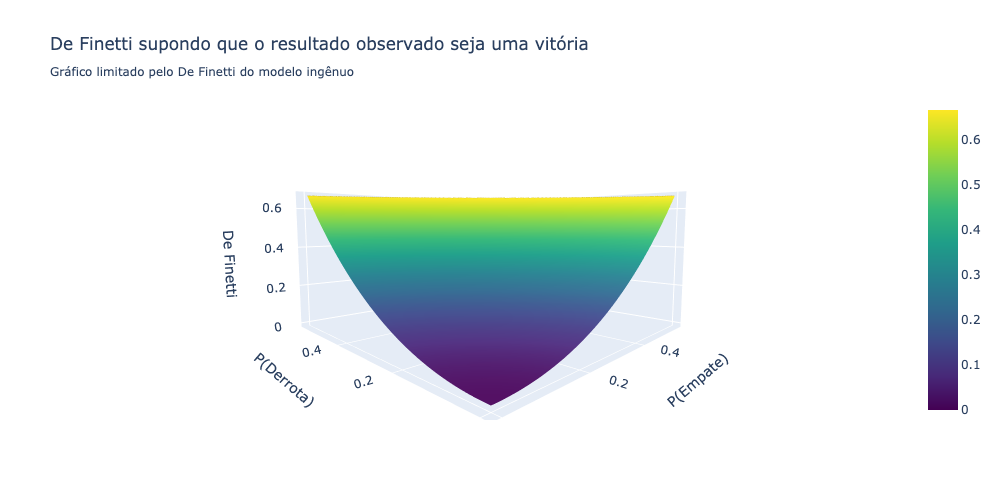

In [14]:
n_points = 500
x = np.linspace(0, .6, n_points)
y = np.linspace(0, .6, n_points)
xv, yv = np.meshgrid(x, y)
zv = xv ** 2 + yv ** 2 + (xv + yv) ** 2

inx = zv > 2/3
xv[inx] = None
yv[inx] = None
zv[inx] = None

fig = go.Figure(go.Surface(x = xv,
                           y = yv,
                           z = zv,
                           colorscale = 'viridis'
                          )
               )

fig.update_layout(scene = dict(
                               xaxis_title = 'P(Empate)',
                               yaxis_title = 'P(Derrota)',
                               zaxis_title = 'De Finetti',
                               aspectmode = 'manual',
                               aspectratio = dict(x = 2, y = 2, z = 1),
                               camera = dict(eye = dict(x = -2, y = -2, z = 0.25),
                                             center = dict(x = 0, y = 0, z = 0))
                              )
                 )

fig.update_layout(width = 1000,
                  title = 'De Finetti supondo que o resultado observado seja uma vitória<br><sub>Gráfico limitado pelo De Finetti do modelo ingênuo</sub>'
                 )

fig.show('png')

## Comparando com outros valores da literatura

| Nome                                               | De Finetti | Jogos | Link     |
| -------------------------------------------------- | ---------- | ----- | -------- |
| Poisson Regression Model - Azhari                  | 0.341      | 10    | [Link](https://iopscience.iop.org/article/10.1088/1742-6596/1108/1/012066/pdf) |
| Bayesian approach - Suzuki e Salasar               | 0.423      | 6     | [Link](https://www.jstor.org/stable/40802329?seq=5&typeAccessWorkflow=login) |
| Poisson regression model - Saraiva e Suzuki        | 0.446      | 20    | [Link](http://www.csam.or.kr/journal/view.html?doi=10.5351/CSAM.2016.23.4.297) |
| Predicting Considering Experts' Opinions - Louzada e Suzuki | 0.483 | 14 | [Link](https://www.scielo.br/j/pope/a/mTchCMVV7BHzTTWNmvyBTgs/?lang=en#) |
| Odds Pinnacle                                      | 0.597      | 4079  | [Link](https://www.football-data.co.uk/new/BRA.csv) |
| Chance de Gol                                      | 0.599      | 42786 | [Link](https://www.chancedegol.com.br/numeros.htm) |
| "Chance" II                                        | 0.620      | 297   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| "Chance" I                                         | 0.623      | 390   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| SD 0                                               | 0.625      | 383   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| Implícito I                                        | 0.625      | 390   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| Poisson Independente                               | 0.626      | ~6000 |          |
| Implícito II                                       | 0.632      | 361   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| Histórico Brasileirão                              | 0.634      | ~6000 |          |
| Baseline ingênuo                                   | 0.666      |       |          |
| SD I                                               | 0.685      | 203   | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
| Implícito III                                      | 0.812      | 64    | [Link](https://www.teses.usp.br/teses/disponiveis/45/45133/tde-19072012-112940/publico/Poison_Bayes_Futebol_e_DeFinetti.pdf) |
